In [2]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sn
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "green", "orange", "purple", "cyan"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  #plt.title(title)
  plt.savefig("../results/plots/{}.png".format(title), dpi=200)
  plt.show()

In [4]:
fname = "../data/datasets.5000a.layer=6.masked=True.pickle"
fname2 = "../data/datasets.5000t.layer=6.masked=True.pickle"

with open(fname, "rb") as f:
    data = pickle.load(f)

    
with open(fname2, "rb") as f:
    data_nonlex = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/datasets.5000a.layer=6.masked=True.pickle'

In [5]:
data.keys()

NameError: name 'data' is not defined

In [14]:
projs_path = "../data/type2P.layer=6.iters=10.classifier=sgd-log.masked=True.pickle"
with open(projs_path, "rb") as f:
    type2proj = pickle.load(f)
    
comps = projs_path.split(".")
layer = comps[-5]
iters = comps[-4]
print(layer, iters)

layer=6 iters=10


In [15]:
data.keys()

dict_keys(['src', 'orc', 'orrc', 'prc', 'prrc', 'all'])

In [21]:
vecs, vecs_rowspace, labels = [],[], []
vecs_rowspace_nonlex = []
k = 300
type2vecs_rowspace = {}
type2vecs_rowspace_nonlex = {}

for type_pos in data.keys():
    
    print(type_pos)
    
    P_rowspace = np.eye(768) - type2proj[type_pos] 
    #P_rowspace = np.eye(768) - type2proj["all"]
    
    train_x, train_y, train_is_rc = data[type_pos]["train"]
    train_x_nonlex, train_y_nonlex, train_y_nonlex_is_rc = data_nonlex[type_pos]["train"]
    
    mask = train_y != 0
    mask_nonlex = train_y_nonlex != 0
    
    relevant_x = train_x[mask]
    relevant_x_nonlex = train_x_nonlex[mask_nonlex]
    
    label = [type_pos] * k
    vecs.append(relevant_x[:k])
    vecs_rowspace.append((relevant_x.dot(P_rowspace))[:k])
    vecs_rowspace_nonlex.append(relevant_x_nonlex.dot(P_rowspace)[:k])
    
    type2vecs_rowspace[type_pos] = relevant_x.dot(P_rowspace)
    type2vecs_rowspace_nonlex[type_pos] = relevant_x_nonlex.dot(P_rowspace)
    
    labels.extend(label)
vecs = np.concatenate(vecs, axis = 0)
vecs_rowspace = np.concatenate(vecs_rowspace, axis = 0)
vecs_rowspace_nonlex = np.concatenate(vecs_rowspace_nonlex, axis = 0)
labels = np.array(labels)
print(vecs.shape, len(labels))

src
orc
orrc
prc
prrc
all
(1800, 768) 1800


In [17]:
print(len(vecs), len(vecs_rowspace))
print(6*300)

1800 1800
1800


In [18]:
type2vecs_rowspace["src"].shape

(6206, 768)

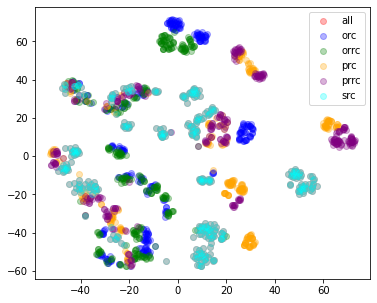

In [19]:
tsne(vecs, labels, "T-sne-original.{}.{}".format(iters, layer))

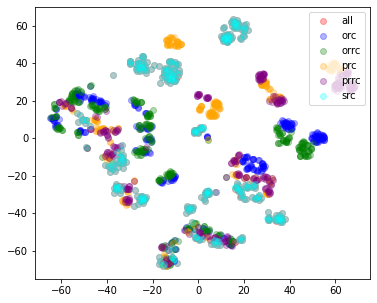

In [22]:
tsne(vecs_rowspace, labels, title = "T-sne-nullspace.{}.{}".format(iters, layer))

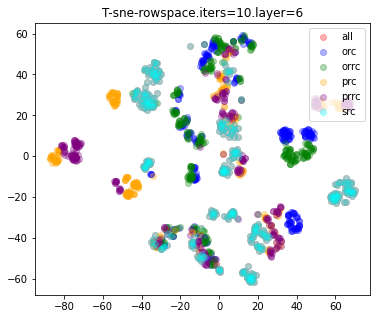

In [14]:
tsne(vecs.dot(type2proj["all"]), labels, title = "T-sne-rowspace.{}.{}".format(iters, layer))

In [13]:
sims = np.zeros((6,6))tsne(vecs_rowspace_nonlex, labels, title = "T-sne-rowspace.non-lexically-overlapped.{}.{}".format(iters, layer))

SyntaxError: invalid syntax (<ipython-input-13-60768eea473e>, line 1)

In [ ]:
sims = np.zeros((6,6))
type2ind = {d:i for i,d in enumerate(type2vecs_rowspace.keys())}
ind2type = {i:d for d,i in type2ind.items()}

In [29]:
type2vecs_rowspace

{'src': array([[ 0.07504236, -0.05461947, -0.38998149, ..., -0.18310728,
          0.05823819,  0.00985634],
        [ 0.03420572, -0.14140763, -0.45426698, ..., -0.09184521,
          0.11441359, -0.06998739],
        [ 0.06482674, -0.1465234 , -0.45819073, ..., -0.04934749,
          0.10996668, -0.08970438],
        ...,
        [ 0.05028231, -0.06359945, -0.31458881, ..., -0.07290135,
          0.07237125, -0.03563104],
        [ 0.03376862, -0.07473614, -0.30435685, ...,  0.02037756,
          0.05088295, -0.04291565],
        [ 0.10338791, -0.04746854, -0.25647341, ..., -0.08291733,
          0.03030737, -0.02902345]]),
 'orc': array([[-0.20611025, -0.27174662, -0.24586494, ...,  0.16156151,
         -0.1927582 , -0.17998258],
        [-0.21897938, -0.28694587, -0.31868013, ...,  0.11004117,
         -0.18080168, -0.22996658],
        [-0.24769803, -0.28523279, -0.31111884, ...,  0.13071323,
         -0.25531645, -0.20864272],
        ...,
        [-0.17881926, -0.27362701, -0.32

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

for key, vecs in type2vecs_rowspace.items():
    for key2, vecs2 in type2vecs_rowspace_nonlex.items():
        #mean1, mean2 = np.mean(vecs, axis = 0), np.mean(vecs2, axis = 0)
        #mean1_normed, mean2_normed = mean1 / np.linalg.norm(mean1), mean2 / np.linalg.norm(mean2)
        
        sims2 = cosine_similarity(vecs, vecs2)
        print(sims2.shape)
        vecs_normed = vecs / np.linalg.norm(vecs, axis = 1, keepdims = True)
        vecs2_normed = vecs2 / np.linalg.norm(vecs2, axis = 1, keepdims = True)
        
        sims[type2ind[key], type2ind[key2]] = np.mean(sims2) #mean1_normed.dot(mean2_normed.T)
        #sims[type2ind[key], type2ind[key2]] = np.mean(vecs.dot(vecs2.T))

(6206, 6402)
(6206, 6305)
(6206, 5116)
(6206, 8721)
(6206, 6305)
(6206, 32849)
(6195, 6402)
(6195, 6305)
(6195, 5116)
(6195, 8721)
(6195, 6305)
(6195, 32849)
(5014, 6402)
(5014, 6305)
(5014, 5116)
(5014, 8721)
(5014, 6305)
(5014, 32849)
(8602, 6402)
(8602, 6305)
(8602, 5116)
(8602, 8721)
(8602, 6305)
(8602, 32849)
(6195, 6402)
(6195, 6305)
(6195, 5116)
(6195, 8721)
(6195, 6305)
(6195, 32849)
(32212, 6402)
(32212, 6305)
(32212, 5116)
(32212, 8721)
(32212, 6305)
(32212, 32849)


In [31]:
type2ind

{'src': 0, 'orc': 1, 'orrc': 2, 'prc': 3, 'prrc': 4, 'all': 5}

In [32]:
print(type2vecs_rowspace["src"].dot(type2vecs_rowspace_nonlex["src"].T).mean())
print(type2vecs_rowspace["src"].dot(type2vecs_rowspace_nonlex["orc"].T).mean())

25.195868585915886
14.635461878285955


In [33]:
labels = [ind2type[i] for i in range(len(ind2type))]


In [34]:
def plot(labels, results, layer, classifier,iters):

    df_cm = pd.DataFrame(results, index = labels,
                  columns = labels)
    
    print(df_cm)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("Cosine similarity in RC subspace between various RCs. {}. classifier: {}. {}".format(layer, classifier, iters))
    plt.show()
    #plt.savefig("../results/plots/original-similarity.pairs:{}.classifier:{}.{}.png".format(layer, classifier, iters), dpi=300)    


           src       orc      orrc       prc      prrc       all
src   0.932012  0.486826  0.390061  0.425861  0.349914  0.550881
orc   0.456432  0.924937  0.528192  0.391953  0.334161  0.537451
orrc  0.373165  0.533047  0.929323  0.293396  0.263229  0.442993
prc   0.424314  0.410769  0.298249  0.937829  0.439095  0.532200
prrc  0.346027  0.364018  0.284947  0.435880  0.875539  0.563577
all   0.534462  0.552218  0.437626  0.524835  0.560183  0.854602


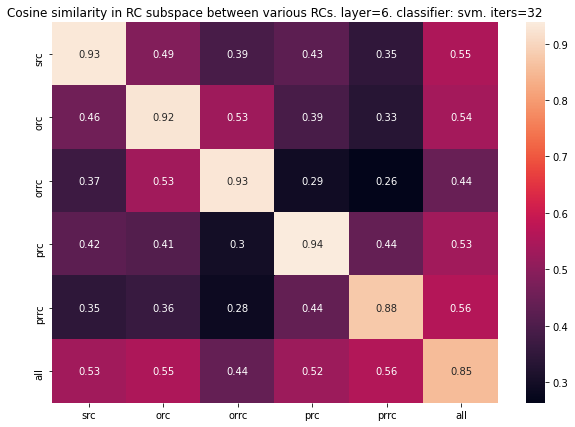

In [35]:
plot(labels, sims, layer, "svm", iters)

           src       orc      orrc       prc      prrc
src   0.730259  0.318402  0.225999  0.189485  0.207873
orc   0.301241  0.787062  0.562664  0.329500  0.315654
orrc  0.220129  0.586864  0.775829  0.294025  0.291838
prc   0.198362  0.393432  0.348137  0.717978  0.362209
prrc  0.199553  0.354041  0.325490  0.352549  0.669115


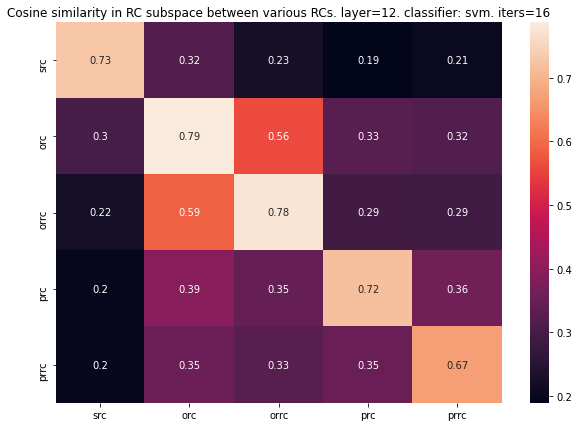

<Figure size 432x288 with 0 Axes>

In [72]:
plot(labels, sims, layer, "svm", iters)